In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C

2024-05-27 16:32:22.970451: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-27 16:32:24.804623: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 16:32:24.805986: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-27 16:32:25.329830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-27 16:32:25.334181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:bd:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13613, 512, 512, 1) (13613, 512, 512, 1) (3153, 512, 512, 1) (3153, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13613, 512, 512, 1) (3153, 512, 512, 1)


In [12]:
X_train, y_train, m_train = C.Helper.filter_slices(X_train, y_train, m_train)

(612, 512, 512, 1) (612, 512, 512, 1) (612, 512, 512, 1)


In [13]:
train_images_array, test_images_array = C.Helper.masked_image(X_train, m_train, X_test, m_test)

(612, 512, 512, 1) (3153, 512, 512, 1)


In [14]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [15]:
train_gen = C.Helper.augment(X_train_set, y_train_set)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [16]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

(2, 512, 512, 1) (2, 512, 512, 1)


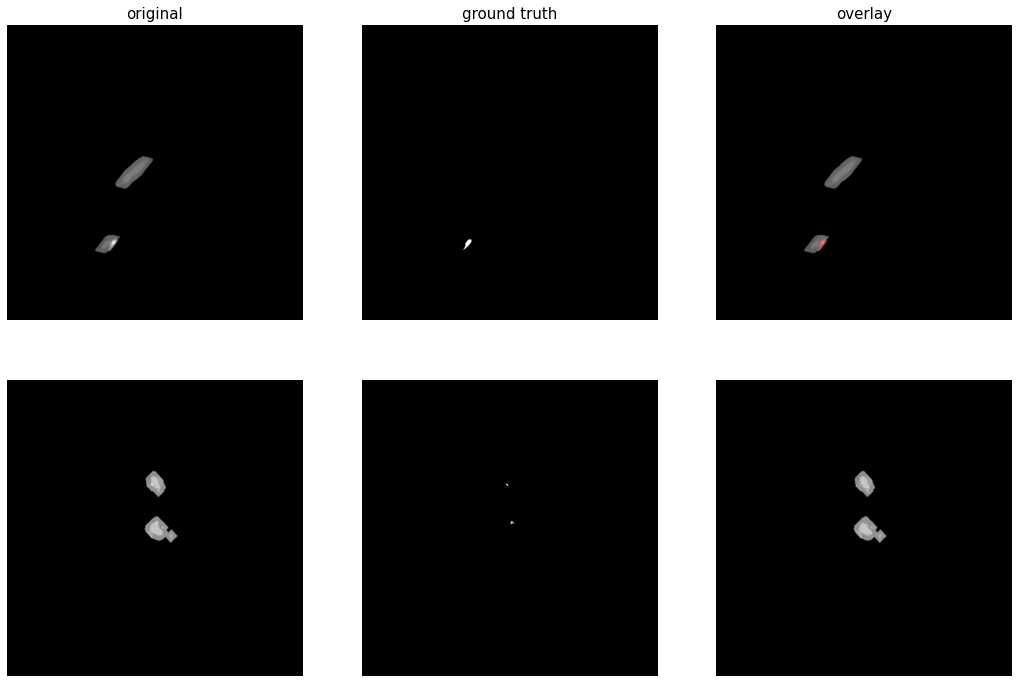

In [17]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [18]:
model = C.Helper.create_unet(X_train_set[0].shape)

2024-05-27 16:35:49.776352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-27 16:35:49.778848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:bd:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-27 16:35:49.788472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-27 16:35:49.791683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-27 16:35:49.794094: I tensorflow/core

In [19]:
model, history = C.Helper.train_unet(train_gen, X_train_set, y_train_set, X_val, y_val, model, epochs=1000)

2024-05-27 16:35:50.460700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-27 16:35:50.461997: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/1000


2024-05-27 16:35:52.087606: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-27 16:35:52.818565: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-27 16:35:53.501742: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-27 16:35:53.501765: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-27 16:35:53.501826: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-27 16:35:53.555263: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-27 16:35:54.304996: I tensorflow/stream_exec

15/15 [==============================] - 17s 689ms/step - loss: 0.7195 - iou: 1.9968e-04 - iou_thresholded: 2.5064e-04 - val_loss: 0.3809 - val_iou: 3.1942e-06 - val_iou_thresholded: 6.2018e-04
Epoch 2/1000
15/15 [==============================] - 2s 166ms/step - loss: 0.5847 - iou: 2.7145e-04 - iou_thresholded: 0.0076 - val_loss: 0.1251 - val_iou: 2.0825e-06 - val_iou_thresholded: 0.0011
Epoch 3/1000
15/15 [==============================] - 2s 167ms/step - loss: 0.5056 - iou: 3.0194e-04 - iou_thresholded: 0.0174 - val_loss: 0.2742 - val_iou: 2.2766e-04 - val_iou_thresholded: 2.1046e-05
Epoch 4/1000
15/15 [==============================] - 2s 166ms/step - loss: 0.4282 - iou: 2.3371e-04 - iou_thresholded: 0.0264 - val_loss: 0.3709 - val_iou: 1.9575e-04 - val_iou_thresholded: 0.0013
Epoch 5/1000
15/15 [==============================] - 2s 167ms/step - loss: 0.3524 - iou: 2.0398e-04 - iou_thresholded: 0.0240 - val_loss: 0.3417 - val_iou: 1.8918e-04 - val_iou_thresholded: 0.0013
Epoch 6/10

Epoch 43/1000
15/15 [==============================] - 2s 166ms/step - loss: 0.0044 - iou: 0.0068 - iou_thresholded: 0.1128 - val_loss: 0.0043 - val_iou: 0.0120 - val_iou_thresholded: 0.1567
Epoch 44/1000
15/15 [==============================] - 2s 167ms/step - loss: 0.0040 - iou: 0.0107 - iou_thresholded: 0.2066 - val_loss: 0.0040 - val_iou: 0.0096 - val_iou_thresholded: 0.1316
Epoch 45/1000
15/15 [==============================] - 2s 166ms/step - loss: 0.0039 - iou: 0.0099 - iou_thresholded: 0.2149 - val_loss: 0.0039 - val_iou: 0.0047 - val_iou_thresholded: 0.0495
Epoch 46/1000
15/15 [==============================] - 2s 166ms/step - loss: 0.0038 - iou: 0.0143 - iou_thresholded: 0.2006 - val_loss: 0.0038 - val_iou: 0.0061 - val_iou_thresholded: 0.0694
Epoch 47/1000
15/15 [==============================] - 2s 167ms/step - loss: 0.0036 - iou: 0.0112 - iou_thresholded: 0.1662 - val_loss: 0.0040 - val_iou: 0.0170 - val_iou_thresholded: 0.1815
Epoch 48/1000
15/15 [========================

Epoch 86/1000
15/15 [==============================] - 2s 166ms/step - loss: 0.0017 - iou: 0.0550 - iou_thresholded: 0.2902 - val_loss: 0.0015 - val_iou: 0.0469 - val_iou_thresholded: 0.2149
Epoch 87/1000
15/15 [==============================] - 2s 167ms/step - loss: 0.0016 - iou: 0.0255 - iou_thresholded: 0.1093 - val_loss: 0.0015 - val_iou: 0.0352 - val_iou_thresholded: 0.1648
Epoch 88/1000
15/15 [==============================] - 3s 179ms/step - loss: 0.0016 - iou: 0.0442 - iou_thresholded: 0.2327 - val_loss: 0.0021 - val_iou: 0.0060 - val_iou_thresholded: 0.0216
Epoch 89/1000
15/15 [==============================] - 2s 168ms/step - loss: 0.0014 - iou: 0.0387 - iou_thresholded: 0.2214 - val_loss: 0.0015 - val_iou: 0.0352 - val_iou_thresholded: 0.1607
Epoch 90/1000
15/15 [==============================] - 2s 167ms/step - loss: 0.0014 - iou: 0.0928 - iou_thresholded: 0.3728 - val_loss: 0.0015 - val_iou: 0.0492 - val_iou_thresholded: 0.2025
Epoch 91/1000
15/15 [========================

15/15 [==============================] - 2s 166ms/step - loss: 9.0088e-04 - iou: 0.0903 - iou_thresholded: 0.2632 - val_loss: 0.0014 - val_iou: 0.0271 - val_iou_thresholded: 0.0658
Epoch 129/1000
15/15 [==============================] - 2s 167ms/step - loss: 7.9329e-04 - iou: 0.0885 - iou_thresholded: 0.2931 - val_loss: 0.0012 - val_iou: 0.0419 - val_iou_thresholded: 0.1052
Epoch 130/1000
15/15 [==============================] - 2s 167ms/step - loss: 9.0077e-04 - iou: 0.0932 - iou_thresholded: 0.2488 - val_loss: 9.8339e-04 - val_iou: 0.0829 - val_iou_thresholded: 0.2233
Epoch 131/1000
15/15 [==============================] - 2s 167ms/step - loss: 9.3117e-04 - iou: 0.0896 - iou_thresholded: 0.2894 - val_loss: 9.9989e-04 - val_iou: 0.1092 - val_iou_thresholded: 0.2997
Epoch 132/1000
15/15 [==============================] - 2s 166ms/step - loss: 0.0011 - iou: 0.1277 - iou_thresholded: 0.3572 - val_loss: 0.0012 - val_iou: 0.1011 - val_iou_thresholded: 0.2517
Epoch 133/1000
15/15 [=========

15/15 [==============================] - 2s 167ms/step - loss: 7.4452e-04 - iou: 0.1170 - iou_thresholded: 0.2713 - val_loss: 8.5516e-04 - val_iou: 0.1053 - val_iou_thresholded: 0.2216
Epoch 170/1000
15/15 [==============================] - 2s 167ms/step - loss: 7.6924e-04 - iou: 0.1565 - iou_thresholded: 0.3052 - val_loss: 9.3096e-04 - val_iou: 0.1237 - val_iou_thresholded: 0.2524
Epoch 171/1000
15/15 [==============================] - 3s 178ms/step - loss: 8.9361e-04 - iou: 0.1457 - iou_thresholded: 0.2744 - val_loss: 9.3692e-04 - val_iou: 0.0888 - val_iou_thresholded: 0.1769
Epoch 172/1000
15/15 [==============================] - 2s 167ms/step - loss: 0.0011 - iou: 0.1270 - iou_thresholded: 0.2631 - val_loss: 9.9281e-04 - val_iou: 0.0894 - val_iou_thresholded: 0.1808
Epoch 173/1000
15/15 [==============================] - 2s 166ms/step - loss: 9.7788e-04 - iou: 0.1547 - iou_thresholded: 0.3074 - val_loss: 9.8373e-04 - val_iou: 0.1033 - val_iou_thresholded: 0.2226
Epoch 174/1000
15/1

15/15 [==============================] - 2s 166ms/step - loss: 6.1944e-04 - iou: 0.1429 - iou_thresholded: 0.2856 - val_loss: 8.0482e-04 - val_iou: 0.1265 - val_iou_thresholded: 0.2193
Epoch 211/1000
15/15 [==============================] - 2s 167ms/step - loss: 7.0368e-04 - iou: 0.1277 - iou_thresholded: 0.2786 - val_loss: 8.6786e-04 - val_iou: 0.1035 - val_iou_thresholded: 0.1678
Epoch 212/1000
15/15 [==============================] - 2s 167ms/step - loss: 7.2029e-04 - iou: 0.1636 - iou_thresholded: 0.2987 - val_loss: 7.0524e-04 - val_iou: 0.1470 - val_iou_thresholded: 0.2706
Epoch 213/1000
15/15 [==============================] - 2s 166ms/step - loss: 4.8944e-04 - iou: 0.1899 - iou_thresholded: 0.3599 - val_loss: 8.1890e-04 - val_iou: 0.1492 - val_iou_thresholded: 0.2726
Epoch 214/1000
15/15 [==============================] - 2s 168ms/step - loss: 6.0682e-04 - iou: 0.1815 - iou_thresholded: 0.3627 - val_loss: 9.3717e-04 - val_iou: 0.1292 - val_iou_thresholded: 0.2142
Epoch 215/1000


15/15 [==============================] - 2s 166ms/step - loss: 5.4732e-04 - iou: 0.2588 - iou_thresholded: 0.4053 - val_loss: 8.4709e-04 - val_iou: 0.1309 - val_iou_thresholded: 0.1831
Epoch 252/1000
15/15 [==============================] - 2s 167ms/step - loss: 6.2756e-04 - iou: 0.1929 - iou_thresholded: 0.3124 - val_loss: 6.9388e-04 - val_iou: 0.1683 - val_iou_thresholded: 0.2584
Epoch 253/1000
15/15 [==============================] - 2s 166ms/step - loss: 5.6787e-04 - iou: 0.2005 - iou_thresholded: 0.3273 - val_loss: 7.3206e-04 - val_iou: 0.1542 - val_iou_thresholded: 0.2350
Epoch 254/1000
15/15 [==============================] - 2s 167ms/step - loss: 7.8583e-04 - iou: 0.1724 - iou_thresholded: 0.2900 - val_loss: 7.4232e-04 - val_iou: 0.1523 - val_iou_thresholded: 0.2252
Epoch 255/1000
15/15 [==============================] - 2s 166ms/step - loss: 7.0384e-04 - iou: 0.2119 - iou_thresholded: 0.3551 - val_loss: 7.2741e-04 - val_iou: 0.1671 - val_iou_thresholded: 0.2479
Epoch 256/1000


15/15 [==============================] - 2s 166ms/step - loss: 0.0011 - iou: 0.2254 - iou_thresholded: 0.3078 - val_loss: 0.0010 - val_iou: 0.0724 - val_iou_thresholded: 0.0923
Epoch 293/1000
15/15 [==============================] - 2s 170ms/step - loss: 6.5766e-04 - iou: 0.0807 - iou_thresholded: 0.1390 - val_loss: 9.7220e-04 - val_iou: 0.0922 - val_iou_thresholded: 0.1277
Epoch 294/1000
15/15 [==============================] - 2s 167ms/step - loss: 7.0543e-04 - iou: 0.1886 - iou_thresholded: 0.3072 - val_loss: 0.0014 - val_iou: 0.0654 - val_iou_thresholded: 0.0830
Epoch 295/1000
15/15 [==============================] - 2s 166ms/step - loss: 6.6718e-04 - iou: 0.2127 - iou_thresholded: 0.3115 - val_loss: 8.8053e-04 - val_iou: 0.1217 - val_iou_thresholded: 0.1592
Epoch 296/1000
15/15 [==============================] - 2s 166ms/step - loss: 5.0098e-04 - iou: 0.2019 - iou_thresholded: 0.3062 - val_loss: 8.0800e-04 - val_iou: 0.1359 - val_iou_thresholded: 0.1831
Epoch 297/1000
15/15 [=====

15/15 [==============================] - 2s 168ms/step - loss: 6.5901e-04 - iou: 0.2416 - iou_thresholded: 0.3806 - val_loss: 6.5363e-04 - val_iou: 0.1807 - val_iou_thresholded: 0.2427
Epoch 334/1000
15/15 [==============================] - 2s 166ms/step - loss: 5.3150e-04 - iou: 0.2233 - iou_thresholded: 0.3518 - val_loss: 6.2883e-04 - val_iou: 0.1779 - val_iou_thresholded: 0.2512
Epoch 335/1000
15/15 [==============================] - 2s 166ms/step - loss: 4.7546e-04 - iou: 0.2334 - iou_thresholded: 0.3395 - val_loss: 6.1014e-04 - val_iou: 0.1912 - val_iou_thresholded: 0.2866
Epoch 336/1000
15/15 [==============================] - 2s 167ms/step - loss: 4.0554e-04 - iou: 0.2277 - iou_thresholded: 0.3387 - val_loss: 6.5143e-04 - val_iou: 0.1866 - val_iou_thresholded: 0.2599
Epoch 337/1000
15/15 [==============================] - 2s 166ms/step - loss: 3.4363e-04 - iou: 0.2925 - iou_thresholded: 0.4431 - val_loss: 8.9942e-04 - val_iou: 0.1781 - val_iou_thresholded: 0.2622
Epoch 338/1000


15/15 [==============================] - 2s 167ms/step - loss: 5.3514e-04 - iou: 0.1973 - iou_thresholded: 0.2988 - val_loss: 6.7746e-04 - val_iou: 0.1552 - val_iou_thresholded: 0.2175
Epoch 375/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.8387e-04 - iou: 0.2016 - iou_thresholded: 0.3053 - val_loss: 6.2348e-04 - val_iou: 0.2013 - val_iou_thresholded: 0.2843
Epoch 376/1000
15/15 [==============================] - 2s 166ms/step - loss: 4.4447e-04 - iou: 0.2664 - iou_thresholded: 0.3764 - val_loss: 6.7020e-04 - val_iou: 0.1962 - val_iou_thresholded: 0.2572
Epoch 377/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.3888e-04 - iou: 0.2198 - iou_thresholded: 0.3136 - val_loss: 6.6288e-04 - val_iou: 0.1828 - val_iou_thresholded: 0.2295
Epoch 378/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.0561e-04 - iou: 0.2347 - iou_thresholded: 0.3774 - val_loss: 7.0718e-04 - val_iou: 0.1773 - val_iou_thresholded: 0.2121
Epoch 379/1000


15/15 [==============================] - 2s 170ms/step - loss: 3.4810e-04 - iou: 0.2370 - iou_thresholded: 0.3697 - val_loss: 9.2861e-04 - val_iou: 0.1426 - val_iou_thresholded: 0.1522
Epoch 416/1000
15/15 [==============================] - 2s 168ms/step - loss: 3.7104e-04 - iou: 0.2524 - iou_thresholded: 0.3635 - val_loss: 8.7535e-04 - val_iou: 0.1377 - val_iou_thresholded: 0.1543
Epoch 417/1000
15/15 [==============================] - 2s 168ms/step - loss: 6.4814e-04 - iou: 0.3452 - iou_thresholded: 0.4682 - val_loss: 5.2960e-04 - val_iou: 0.2642 - val_iou_thresholded: 0.4237
Epoch 418/1000
15/15 [==============================] - 2s 166ms/step - loss: 6.2929e-04 - iou: 0.2815 - iou_thresholded: 0.3961 - val_loss: 5.4886e-04 - val_iou: 0.2478 - val_iou_thresholded: 0.3861
Epoch 419/1000
15/15 [==============================] - 2s 167ms/step - loss: 4.7858e-04 - iou: 0.2480 - iou_thresholded: 0.3805 - val_loss: 6.8697e-04 - val_iou: 0.1513 - val_iou_thresholded: 0.1866
Epoch 420/1000


15/15 [==============================] - 2s 166ms/step - loss: 4.7596e-04 - iou: 0.3158 - iou_thresholded: 0.4095 - val_loss: 5.9747e-04 - val_iou: 0.2863 - val_iou_thresholded: 0.3772
Epoch 457/1000
15/15 [==============================] - 2s 166ms/step - loss: 8.0924e-04 - iou: 0.2741 - iou_thresholded: 0.3760 - val_loss: 0.0011 - val_iou: 0.0808 - val_iou_thresholded: 0.0738
Epoch 458/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.1805e-04 - iou: 0.2810 - iou_thresholded: 0.3785 - val_loss: 6.4624e-04 - val_iou: 0.1752 - val_iou_thresholded: 0.2221
Epoch 459/1000
15/15 [==============================] - 3s 172ms/step - loss: 4.3499e-04 - iou: 0.2059 - iou_thresholded: 0.2996 - val_loss: 6.1371e-04 - val_iou: 0.2308 - val_iou_thresholded: 0.2924
Epoch 460/1000
15/15 [==============================] - 2s 167ms/step - loss: 6.1055e-04 - iou: 0.2185 - iou_thresholded: 0.3052 - val_loss: 7.5786e-04 - val_iou: 0.1519 - val_iou_thresholded: 0.1558
Epoch 461/1000
15/1

15/15 [==============================] - 2s 166ms/step - loss: 4.5488e-04 - iou: 0.2680 - iou_thresholded: 0.3328 - val_loss: 9.6513e-04 - val_iou: 0.0879 - val_iou_thresholded: 0.2548
Epoch 498/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.3151e-04 - iou: 0.2381 - iou_thresholded: 0.3097 - val_loss: 0.0022 - val_iou: 0.0045 - val_iou_thresholded: 0.0048
Epoch 499/1000
15/15 [==============================] - 2s 166ms/step - loss: 3.3418e-04 - iou: 0.2627 - iou_thresholded: 0.3207 - val_loss: 0.0012 - val_iou: 0.0842 - val_iou_thresholded: 0.1634
Epoch 500/1000
15/15 [==============================] - 2s 167ms/step - loss: 4.6801e-04 - iou: 0.2982 - iou_thresholded: 0.4067 - val_loss: 7.0281e-04 - val_iou: 0.1580 - val_iou_thresholded: 0.2884
Epoch 501/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.7057e-04 - iou: 0.2667 - iou_thresholded: 0.3418 - val_loss: 5.7323e-04 - val_iou: 0.2135 - val_iou_thresholded: 0.3389
Epoch 502/1000
15/15 [=

15/15 [==============================] - 2s 168ms/step - loss: 5.5254e-04 - iou: 0.3614 - iou_thresholded: 0.4946 - val_loss: 5.0818e-04 - val_iou: 0.2843 - val_iou_thresholded: 0.3518
Epoch 539/1000
15/15 [==============================] - 2s 167ms/step - loss: 6.5764e-04 - iou: 0.2505 - iou_thresholded: 0.3573 - val_loss: 5.4985e-04 - val_iou: 0.2221 - val_iou_thresholded: 0.2658
Epoch 540/1000
15/15 [==============================] - 2s 167ms/step - loss: 4.2044e-04 - iou: 0.3140 - iou_thresholded: 0.4205 - val_loss: 4.7492e-04 - val_iou: 0.3043 - val_iou_thresholded: 0.3960
Epoch 541/1000
15/15 [==============================] - 2s 167ms/step - loss: 6.2395e-04 - iou: 0.3424 - iou_thresholded: 0.4431 - val_loss: 4.5625e-04 - val_iou: 0.2882 - val_iou_thresholded: 0.3633
Epoch 542/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.6772e-04 - iou: 0.2831 - iou_thresholded: 0.3756 - val_loss: 4.8392e-04 - val_iou: 0.2806 - val_iou_thresholded: 0.3989
Epoch 543/1000


15/15 [==============================] - 2s 167ms/step - loss: 4.2323e-04 - iou: 0.2209 - iou_thresholded: 0.2589 - val_loss: 4.9717e-04 - val_iou: 0.3084 - val_iou_thresholded: 0.3924
Epoch 580/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.4260e-04 - iou: 0.3433 - iou_thresholded: 0.4626 - val_loss: 6.2945e-04 - val_iou: 0.2597 - val_iou_thresholded: 0.2978
Epoch 581/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.5944e-04 - iou: 0.4319 - iou_thresholded: 0.5736 - val_loss: 4.4856e-04 - val_iou: 0.3653 - val_iou_thresholded: 0.4834
Epoch 582/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.3614e-04 - iou: 0.3019 - iou_thresholded: 0.3990 - val_loss: 4.2518e-04 - val_iou: 0.3484 - val_iou_thresholded: 0.4815
Epoch 583/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.4347e-04 - iou: 0.3716 - iou_thresholded: 0.4833 - val_loss: 5.1844e-04 - val_iou: 0.2977 - val_iou_thresholded: 0.3401
Epoch 584/1000


15/15 [==============================] - 2s 168ms/step - loss: 5.0218e-04 - iou: 0.2822 - iou_thresholded: 0.3575 - val_loss: 5.8339e-04 - val_iou: 0.2319 - val_iou_thresholded: 0.3909
Epoch 621/1000
15/15 [==============================] - 2s 167ms/step - loss: 4.3178e-04 - iou: 0.3535 - iou_thresholded: 0.4810 - val_loss: 4.6993e-04 - val_iou: 0.3293 - val_iou_thresholded: 0.4318
Epoch 622/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.2675e-04 - iou: 0.3091 - iou_thresholded: 0.4476 - val_loss: 3.5259e-04 - val_iou: 0.3782 - val_iou_thresholded: 0.5975
Epoch 623/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.5527e-04 - iou: 0.3074 - iou_thresholded: 0.4194 - val_loss: 4.3174e-04 - val_iou: 0.2886 - val_iou_thresholded: 0.4684
Epoch 624/1000
15/15 [==============================] - 2s 170ms/step - loss: 3.3763e-04 - iou: 0.3699 - iou_thresholded: 0.4953 - val_loss: 6.7046e-04 - val_iou: 0.1851 - val_iou_thresholded: 0.2141
Epoch 625/1000


15/15 [==============================] - 2s 168ms/step - loss: 3.8690e-04 - iou: 0.3677 - iou_thresholded: 0.5049 - val_loss: 6.3565e-04 - val_iou: 0.2187 - val_iou_thresholded: 0.2269
Epoch 662/1000
15/15 [==============================] - 2s 166ms/step - loss: 4.2360e-04 - iou: 0.2355 - iou_thresholded: 0.3413 - val_loss: 5.2007e-04 - val_iou: 0.2710 - val_iou_thresholded: 0.3550
Epoch 663/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.4140e-04 - iou: 0.3076 - iou_thresholded: 0.3933 - val_loss: 4.4988e-04 - val_iou: 0.3412 - val_iou_thresholded: 0.4261
Epoch 664/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.5966e-04 - iou: 0.4176 - iou_thresholded: 0.5726 - val_loss: 4.0518e-04 - val_iou: 0.3828 - val_iou_thresholded: 0.4890
Epoch 665/1000
15/15 [==============================] - 2s 168ms/step - loss: 5.5922e-04 - iou: 0.3551 - iou_thresholded: 0.4590 - val_loss: 3.5287e-04 - val_iou: 0.3583 - val_iou_thresholded: 0.5323
Epoch 666/1000


15/15 [==============================] - 2s 167ms/step - loss: 2.9839e-04 - iou: 0.3956 - iou_thresholded: 0.5198 - val_loss: 4.4826e-04 - val_iou: 0.3572 - val_iou_thresholded: 0.4052
Epoch 703/1000
15/15 [==============================] - 2s 167ms/step - loss: 2.7822e-04 - iou: 0.3793 - iou_thresholded: 0.5022 - val_loss: 5.5415e-04 - val_iou: 0.3123 - val_iou_thresholded: 0.3143
Epoch 704/1000
15/15 [==============================] - 3s 167ms/step - loss: 2.7893e-04 - iou: 0.4300 - iou_thresholded: 0.5142 - val_loss: 4.7069e-04 - val_iou: 0.3962 - val_iou_thresholded: 0.4713
Epoch 705/1000
15/15 [==============================] - 2s 167ms/step - loss: 6.7000e-04 - iou: 0.3917 - iou_thresholded: 0.4961 - val_loss: 6.5906e-04 - val_iou: 0.2456 - val_iou_thresholded: 0.2770
Epoch 706/1000
15/15 [==============================] - 2s 166ms/step - loss: 3.2666e-04 - iou: 0.3248 - iou_thresholded: 0.4478 - val_loss: 4.4423e-04 - val_iou: 0.2830 - val_iou_thresholded: 0.4363
Epoch 707/1000


15/15 [==============================] - 2s 166ms/step - loss: 4.0930e-04 - iou: 0.3418 - iou_thresholded: 0.4216 - val_loss: 3.9581e-04 - val_iou: 0.3370 - val_iou_thresholded: 0.5280
Epoch 744/1000
15/15 [==============================] - 2s 166ms/step - loss: 2.8210e-04 - iou: 0.4518 - iou_thresholded: 0.5868 - val_loss: 5.5005e-04 - val_iou: 0.3600 - val_iou_thresholded: 0.4728
Epoch 745/1000
15/15 [==============================] - 2s 166ms/step - loss: 7.1971e-04 - iou: 0.2922 - iou_thresholded: 0.3722 - val_loss: 4.6171e-04 - val_iou: 0.2769 - val_iou_thresholded: 0.3335
Epoch 746/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.5354e-04 - iou: 0.2761 - iou_thresholded: 0.3809 - val_loss: 4.3512e-04 - val_iou: 0.3590 - val_iou_thresholded: 0.4338
Epoch 747/1000
15/15 [==============================] - 2s 166ms/step - loss: 6.1055e-04 - iou: 0.2502 - iou_thresholded: 0.3187 - val_loss: 7.7033e-04 - val_iou: 0.2312 - val_iou_thresholded: 0.2336
Epoch 748/1000


15/15 [==============================] - 2s 167ms/step - loss: 3.7618e-04 - iou: 0.3454 - iou_thresholded: 0.4630 - val_loss: 3.8467e-04 - val_iou: 0.4221 - val_iou_thresholded: 0.5470
Epoch 785/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.3780e-04 - iou: 0.3855 - iou_thresholded: 0.5108 - val_loss: 3.7867e-04 - val_iou: 0.3767 - val_iou_thresholded: 0.4968
Epoch 786/1000
15/15 [==============================] - 2s 166ms/step - loss: 3.2522e-04 - iou: 0.4259 - iou_thresholded: 0.5553 - val_loss: 3.5157e-04 - val_iou: 0.3828 - val_iou_thresholded: 0.5290
Epoch 787/1000
15/15 [==============================] - 2s 168ms/step - loss: 5.2925e-04 - iou: 0.3508 - iou_thresholded: 0.4586 - val_loss: 4.3938e-04 - val_iou: 0.3828 - val_iou_thresholded: 0.4751
Epoch 788/1000
15/15 [==============================] - 2s 167ms/step - loss: 5.1528e-04 - iou: 0.3894 - iou_thresholded: 0.4979 - val_loss: 4.5950e-04 - val_iou: 0.3380 - val_iou_thresholded: 0.3734
Epoch 789/1000


15/15 [==============================] - 2s 167ms/step - loss: 2.6561e-04 - iou: 0.4623 - iou_thresholded: 0.6034 - val_loss: 4.7264e-04 - val_iou: 0.3570 - val_iou_thresholded: 0.4544
Epoch 826/1000
15/15 [==============================] - 2s 167ms/step - loss: 4.6310e-04 - iou: 0.4236 - iou_thresholded: 0.5474 - val_loss: 4.6505e-04 - val_iou: 0.3052 - val_iou_thresholded: 0.3809
Epoch 827/1000
15/15 [==============================] - 2s 166ms/step - loss: 3.1600e-04 - iou: 0.2889 - iou_thresholded: 0.4039 - val_loss: 4.2672e-04 - val_iou: 0.3288 - val_iou_thresholded: 0.4222
Epoch 828/1000
15/15 [==============================] - 2s 169ms/step - loss: 3.8862e-04 - iou: 0.3814 - iou_thresholded: 0.5189 - val_loss: 4.0275e-04 - val_iou: 0.3757 - val_iou_thresholded: 0.4948
Epoch 829/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.4813e-04 - iou: 0.3285 - iou_thresholded: 0.4044 - val_loss: 3.3966e-04 - val_iou: 0.4103 - val_iou_thresholded: 0.5216
Epoch 830/1000


15/15 [==============================] - 2s 167ms/step - loss: 4.0477e-04 - iou: 0.3250 - iou_thresholded: 0.4411 - val_loss: 3.1959e-04 - val_iou: 0.4354 - val_iou_thresholded: 0.6097
Epoch 867/1000
15/15 [==============================] - 2s 166ms/step - loss: 2.3053e-04 - iou: 0.3614 - iou_thresholded: 0.4567 - val_loss: 4.6972e-04 - val_iou: 0.3929 - val_iou_thresholded: 0.4480
Epoch 868/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.4593e-04 - iou: 0.4403 - iou_thresholded: 0.5530 - val_loss: 3.3953e-04 - val_iou: 0.4569 - val_iou_thresholded: 0.5847
Epoch 869/1000
15/15 [==============================] - 2s 167ms/step - loss: 2.8700e-04 - iou: 0.3759 - iou_thresholded: 0.4568 - val_loss: 3.6407e-04 - val_iou: 0.4208 - val_iou_thresholded: 0.5210
Epoch 870/1000
15/15 [==============================] - 2s 169ms/step - loss: 2.4812e-04 - iou: 0.4047 - iou_thresholded: 0.5267 - val_loss: 3.3290e-04 - val_iou: 0.4230 - val_iou_thresholded: 0.5533
Epoch 871/1000


15/15 [==============================] - 2s 166ms/step - loss: 4.2209e-04 - iou: 0.4209 - iou_thresholded: 0.5282 - val_loss: 4.6656e-04 - val_iou: 0.3769 - val_iou_thresholded: 0.4451
Epoch 908/1000
15/15 [==============================] - 2s 166ms/step - loss: 2.7699e-04 - iou: 0.3885 - iou_thresholded: 0.5185 - val_loss: 6.6878e-04 - val_iou: 0.3534 - val_iou_thresholded: 0.4059
Epoch 909/1000
15/15 [==============================] - 2s 168ms/step - loss: 5.3978e-04 - iou: 0.4085 - iou_thresholded: 0.5354 - val_loss: 3.8103e-04 - val_iou: 0.3465 - val_iou_thresholded: 0.6090
Epoch 910/1000
15/15 [==============================] - 2s 167ms/step - loss: 3.4186e-04 - iou: 0.1975 - iou_thresholded: 0.2223 - val_loss: 3.7403e-04 - val_iou: 0.2752 - val_iou_thresholded: 0.4170
Epoch 911/1000
15/15 [==============================] - 2s 166ms/step - loss: 2.9099e-04 - iou: 0.3406 - iou_thresholded: 0.4579 - val_loss: 5.0695e-04 - val_iou: 0.3195 - val_iou_thresholded: 0.3531
Epoch 912/1000


15/15 [==============================] - 2s 166ms/step - loss: 3.1591e-04 - iou: 0.4328 - iou_thresholded: 0.6099 - val_loss: 2.9549e-04 - val_iou: 0.4621 - val_iou_thresholded: 0.5901
Epoch 949/1000
15/15 [==============================] - 2s 166ms/step - loss: 2.4939e-04 - iou: 0.4204 - iou_thresholded: 0.5617 - val_loss: 2.9748e-04 - val_iou: 0.4678 - val_iou_thresholded: 0.5569
Epoch 950/1000
15/15 [==============================] - 3s 182ms/step - loss: 3.7009e-04 - iou: 0.4529 - iou_thresholded: 0.5756 - val_loss: 2.8576e-04 - val_iou: 0.4914 - val_iou_thresholded: 0.6300
Epoch 951/1000
15/15 [==============================] - 2s 166ms/step - loss: 2.4770e-04 - iou: 0.4090 - iou_thresholded: 0.4804 - val_loss: 3.4660e-04 - val_iou: 0.4184 - val_iou_thresholded: 0.4839
Epoch 952/1000
15/15 [==============================] - 2s 167ms/step - loss: 2.7852e-04 - iou: 0.3966 - iou_thresholded: 0.5241 - val_loss: 3.6513e-04 - val_iou: 0.4234 - val_iou_thresholded: 0.5229
Epoch 953/1000


15/15 [==============================] - 2s 166ms/step - loss: 4.0495e-04 - iou: 0.4172 - iou_thresholded: 0.5416 - val_loss: 2.9345e-04 - val_iou: 0.4823 - val_iou_thresholded: 0.6428
Epoch 990/1000
15/15 [==============================] - 2s 166ms/step - loss: 3.8735e-04 - iou: 0.2871 - iou_thresholded: 0.3392 - val_loss: 3.6169e-04 - val_iou: 0.3848 - val_iou_thresholded: 0.4388
Epoch 991/1000
15/15 [==============================] - 2s 168ms/step - loss: 3.4637e-04 - iou: 0.3931 - iou_thresholded: 0.5149 - val_loss: 4.0533e-04 - val_iou: 0.3973 - val_iou_thresholded: 0.4430
Epoch 992/1000
15/15 [==============================] - 2s 166ms/step - loss: 2.8993e-04 - iou: 0.3786 - iou_thresholded: 0.4803 - val_loss: 3.0199e-04 - val_iou: 0.4857 - val_iou_thresholded: 0.6104
Epoch 993/1000
15/15 [==============================] - 2s 166ms/step - loss: 3.0019e-04 - iou: 0.4026 - iou_thresholded: 0.5325 - val_loss: 3.6409e-04 - val_iou: 0.4371 - val_iou_thresholded: 0.5384
Epoch 994/1000


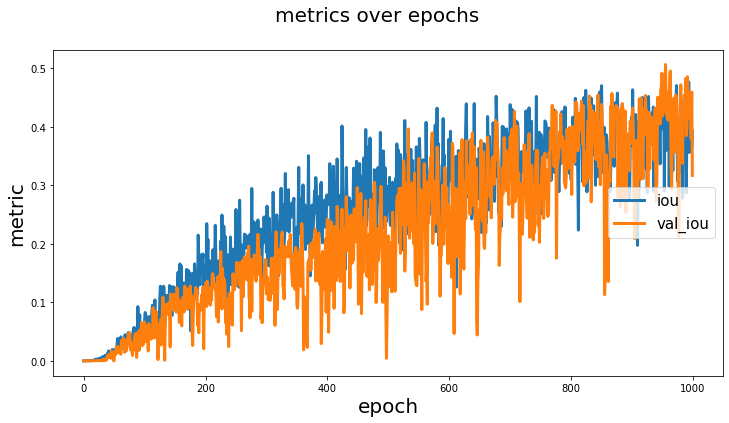

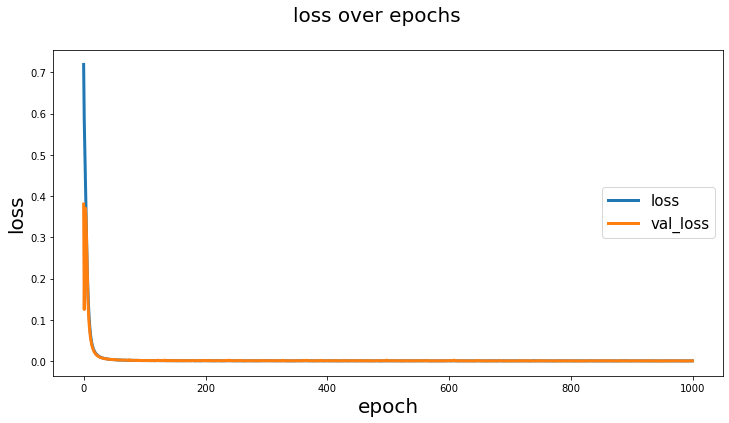

In [20]:
C.Helper.visualize_graph(history)

In [21]:
y_pred = C.Helper.prediction(test_images_array, model)

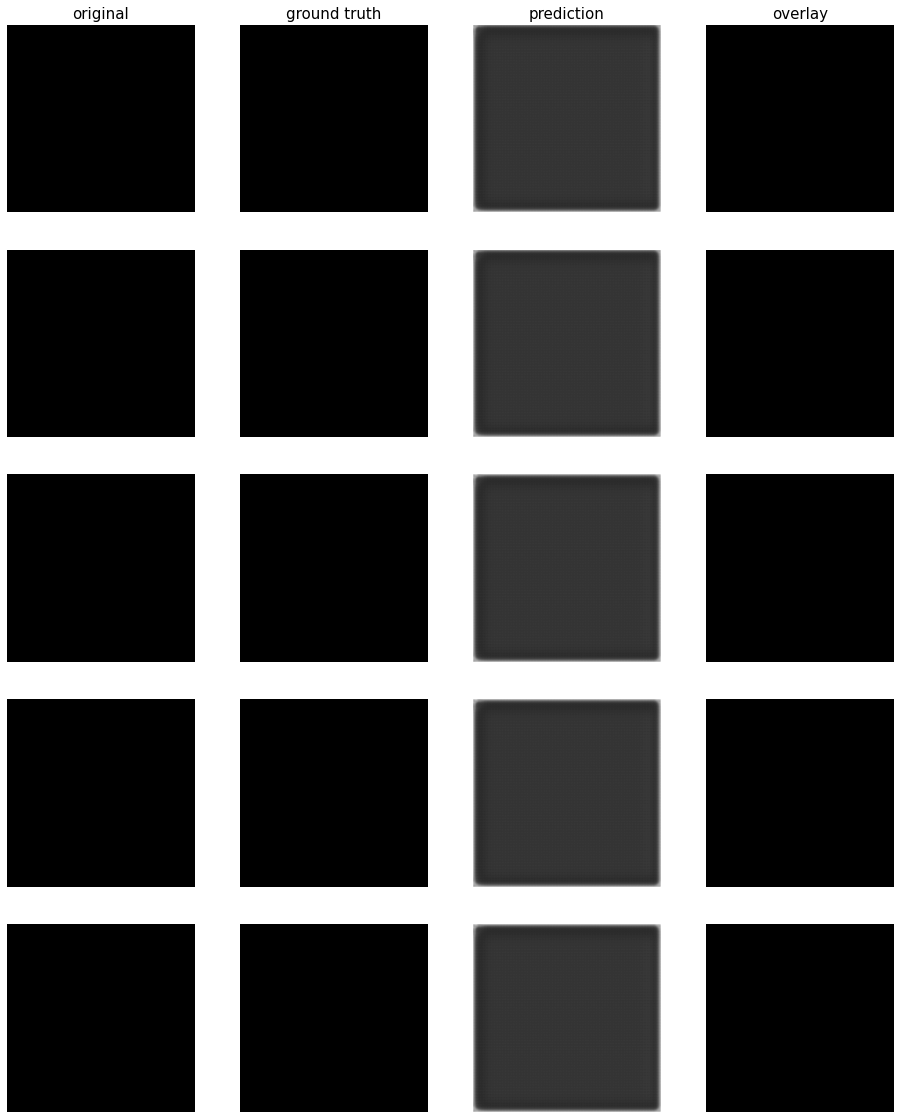

In [22]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [23]:
C.Helper.evaluate(test_images_array, y_test, model)

99/99 [==============================] - 26s 256ms/step - loss: 2.3665e-05 - iou: 0.0538 - iou_thresholded: 0.7271
